<a href="https://colab.research.google.com/github/MaxYarosh/ML-projects/blob/main/decision_tree_%2B_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [16]:
# --- Критерії чистоти ---
def gini(y):
    m = len(y)
    counts = np.bincount(y)
    return 1 - sum((count/m)**2 for count in counts if count>0)

def entropy(y):
    m = len(y)
    counts = np.bincount(y)
    return -sum((count/m) * np.log2(count/m) for count in counts if count>0)

In [17]:
# --- Базове дерево рішень ---
class DecisionTreeNode:
    def __init__(self, depth=0, max_depth=5, criterion='gini'):
        self.left = None
        self.right = None
        self.feature_index = None
        self.threshold = None
        self.value = None
        self.depth = depth
        self.max_depth = max_depth
        self.criterion = criterion

    def _impurity(self, y):
        if self.criterion == 'gini':
            return gini(y)
        else:
            return entropy(y)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        # якщо всі мітки однакові або досягнуто max_depth
        if len(set(y)) == 1 or self.depth >= self.max_depth:
            self.value = Counter(y).most_common(1)[0][0]
            return

        # шукаємо найкраще розбиття
        best_impurity = float('inf')
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                left_mask = X[:, feature] <= t
                right_mask = X[:, feature] > t
                if sum(left_mask) == 0 or sum(right_mask) == 0:
                    continue
                impurity = (len(y[left_mask])/len(y))*self._impurity(y[left_mask]) + \
                           (len(y[right_mask])/len(y))*self._impurity(y[right_mask])
                if impurity < best_impurity:
                    best_impurity = impurity
                    self.feature_index = feature
                    self.threshold = t

        if self.feature_index is None:
            self.value = Counter(y).most_common(1)[0][0]
            return

        # рекурсивно будуємо піддерева
        left_mask = X[:, self.feature_index] <= self.threshold
        right_mask = X[:, self.feature_index] > self.threshold
        self.left = DecisionTreeNode(depth=self.depth+1, max_depth=self.max_depth, criterion=self.criterion)
        self.left.fit(X[left_mask], y[left_mask])
        self.right = DecisionTreeNode(depth=self.depth+1, max_depth=self.max_depth, criterion=self.criterion)
        self.right.fit(X[right_mask], y[right_mask])

    def predict_single(self, x):
        if self.value is not None:
            return self.value
        if x[self.feature_index] <= self.threshold:
            return self.left.predict_single(x)
        else:
            return self.right.predict_single(x)

    def predict(self, X):
        return np.array([self.predict_single(x) for x in X])

In [18]:
# ---  Дані ---
X, y = make_classification(
    n_samples=500, n_features=4, n_informative=4, n_redundant=0,
    n_classes=2, random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# --- Тест власного дерева ---
tree_gini = DecisionTreeNode(max_depth=5, criterion='gini')
tree_gini.fit(X_train, y_train)
y_pred_gini = tree_gini.predict(X_test)
print("Custom Decision Tree (Gini) Accuracy:", accuracy_score(y_test, y_pred_gini))

tree_entropy = DecisionTreeNode(max_depth=5, criterion='entropy')
tree_entropy.fit(X_train, y_train)
y_pred_entropy = tree_entropy.predict(X_test)
print("Custom Decision Tree (Entropy) Accuracy:", accuracy_score(y_test, y_pred_entropy))

Custom Decision Tree (Gini) Accuracy: 0.8
Custom Decision Tree (Entropy) Accuracy: 0.74


In [20]:
# ---  sklearn для порівняння ---
sk_tree_gini = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
sk_tree_gini.fit(X_train, y_train)
y_pred_sk_gini = sk_tree_gini.predict(X_test)
print("sklearn Decision Tree (Gini) Accuracy:", accuracy_score(y_test, y_pred_sk_gini))

sk_tree_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
sk_tree_entropy.fit(X_train, y_train)
y_pred_sk_entropy = sk_tree_entropy.predict(X_test)
print("sklearn Decision Tree (Entropy) Accuracy:", accuracy_score(y_test, y_pred_sk_entropy))

sklearn Decision Tree (Gini) Accuracy: 0.79
sklearn Decision Tree (Entropy) Accuracy: 0.73


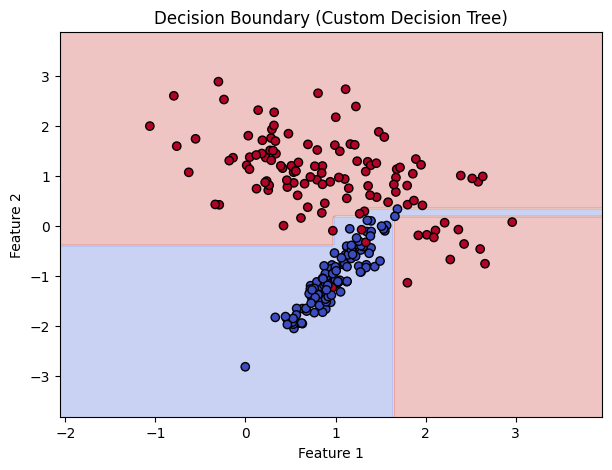

In [21]:
X_2d, y_2d = make_classification(
    n_samples=300, n_features=2, n_informative=2, n_redundant=0,
    n_clusters_per_class=1, random_state=42
)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2d, y_2d, test_size=0.2, random_state=42)


tree_vis = DecisionTreeNode(max_depth=5, criterion='gini')
tree_vis.fit(X_train2, y_train2)

def plot_decision_boundary_2d(X, y, model, resolution=200):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary (Custom Decision Tree)")


plt.figure(figsize=(7,5))
plot_decision_boundary_2d(X_train2, y_train2, tree_vis)
plt.show()


In [9]:
# --- Реалізація Random Forest ---
class RandomForest:
    def __init__(self, n_trees=10, max_depth=5, criterion='gini', max_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.criterion = criterion
        self.trees = []
        self.max_features = max_features

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[idxs], y[idxs]

    def fit(self, X, y):
        self.trees = []
        n_features = X.shape[1]
        if self.max_features is None:
            self.max_features = int(np.sqrt(n_features))

        for _ in range(self.n_trees):
            X_sample, y_sample = self._bootstrap_sample(X, y)
            features_idx = np.random.choice(n_features, size=self.max_features, replace=False)
            tree = DecisionTreeNode(max_depth=self.max_depth, criterion=self.criterion)
            tree.fit(X_sample[:, features_idx], y_sample)
            self.trees.append((tree, features_idx))

    def predict(self, X):
        tree_preds = []
        for tree, features_idx in self.trees:
            pred = tree.predict(X[:, features_idx])
            tree_preds.append(pred)
        tree_preds = np.array(tree_preds)
        y_pred = []
        for col in tree_preds.T:
            y_pred.append(Counter(col).most_common(1)[0][0])
        return np.array(y_pred)

Custom Random Forest Accuracy: 0.75
Sklearn Random Forest Accuracy: 0.83


In [22]:
# --- Дані ---
X, y = make_classification(
    n_samples=500, n_features=4, n_informative=4, n_redundant=0,
    n_classes=2, random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# --- Custom Random Forest  ---
rf_custom = RandomForest(n_trees=10, max_depth=5, criterion='gini')
rf_custom.fit(X_train, y_train)
y_pred_custom = rf_custom.predict(X_test)
print("Custom Random Forest Accuracy:", accuracy_score(y_test, y_pred_custom))

# --- 4. Sklearn Random Forest ---
rf_sklearn = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=42)
rf_sklearn.fit(X_train, y_train)
y_pred_sklearn = rf_sklearn.predict(X_test)
print("Sklearn Random Forest Accuracy:", accuracy_score(y_test, y_pred_sklearn))


Custom Random Forest Accuracy: 0.79
Sklearn Random Forest Accuracy: 0.83
